In [1]:
import mlc_func as mlcf
import numpy as np
import pandas as pd
import keras
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [25]:
def create_target_file(baseline, reference, output, offset = 0):
    targets = np.genfromtxt(reference, delimiter = ',') -\
        np.genfromtxt(baseline, delimiter = ',') - offset
#     species = np.array(['o','h','h']*int(len(targets)/3)).reshape(-1,1)
#     targets = np.concatenate([targets,species], axis = 1)
    pd.DataFrame(targets).to_csv(output, index = None, header = None)

In [36]:
# basepath_feat = '../data/PBE/szp/basis_long_elf.json_processed/'
# basepath_tar = '../data/PBE/szp/'
# revpath_tar = '../data/MB-pol'

basepath_feat = '../data/PBE/dz_custom/basis_nocore_nn.json_processed/'
basepath_tar = '../data/PBE/dz_custom/'
revpath_tar = '../data/MB-pol/'

# systems = ['monomers','dimers','trimers']
systems = ['16p16']
mono_offset = 0
n_mol = [3,2,1]
# filters = [([True,True] + [False]*10)*3000]

for s,nm in zip(systems, n_mol):
    create_target_file(basepath_tar +'/{}.forces'.format(s),
                      revpath_tar + '/{}.forces'.format(s),
                      basepath_tar +'/{}_targets.forces'.format(s), mono_offset*nm)
        
feature_src = [basepath_feat + s +'_processed.hdf5' for s in systems]
target_src = [basepath_tar +'/' + s +'_targets.forces' for s in systems]
traj_src = [basepath_tar +'/' + s +'.traj' for s in systems]
# filters = np.genfromtxt('../data/BH/dz_custom_padded/filter.idx', dtype =bool)
# filters = np.array([filters, filters]).T.flatten()
nn = mlcf.ml.build_force_mlcf(feature_src, target_src,traj_src, filters =[], automask_std = 1e-3,
                                  autofilt_percent = 0.005, species = 'h')


{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
(16384, 8)


In [28]:
old_scaler = nn.scaler

In [67]:
nn.load_all('../../elf_models/mlcf_master/16p16/pbedz_mbp_elf/')

/home/sebastian/miniconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [68]:
nn.X_test = nn.scaler.transform(old_scaler.inverse_transform(nn.X_test))
nn.X_train = nn.scaler.transform(old_scaler.inverse_transform(nn.X_train))
nn.X_valid = nn.scaler.transform(old_scaler.inverse_transform(nn.X_valid))

ValueError: operands could not be broadcast together with shapes (1229,5) (6,) (1229,5) 

In [60]:
# nn.model = keras.models.load_model('../../elf_models/mlcf_master/16p16/pbesz_mbp_long/force_o')

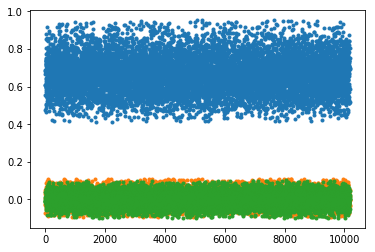

In [37]:
plot(nn.y_train,ls = '', marker = '.')


In [29]:
# learning_curve = nn.learning_curve(steps=8)

In [38]:
nn.nodes_per_layer = 16

In [39]:
nn.train(early_stopping=True, b=1e-8,batch_size=500, restart = False)

--------Epoch = 0----------
Training loss || Validation loss
     0.435437 ||      0.435959
--------Epoch = 500----------
Training loss || Validation loss
     0.047681 ||      0.047713
--------Epoch = 1000----------
Training loss || Validation loss
     0.047484 ||      0.047632


KeyboardInterrupt: 

======== Evaluation on test set =============
              RMSE =  0.0536
              MAE = 0.0412
              Max. abs. error = 0.2972


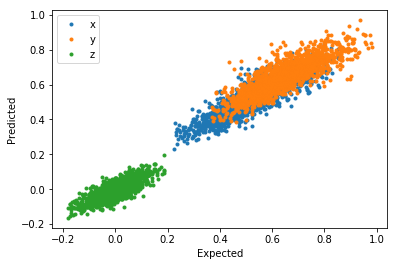

{'rmse': 0.05356749517611435,
 'mae': 0.04122728535295055,
 'max': 0.2971947977332541}

In [32]:
nn.evaluate(plot=True, on='test')

======== Evaluation on test set =============
              RMSE =  0.0536
              MAE = 0.0412
              Max. abs. error = 0.2972


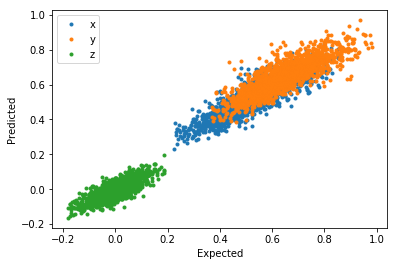

{'rmse': 0.05356749517611435,
 'mae': 0.04122728535295055,
 'max': 0.2971947977332541}

In [33]:
nn.evaluate(plot=True, on='test')

In [40]:
nn.save_all('../../elf_models/mlcf_master/tests/pbe_to_mbp/', override=True)

In [35]:
ensemble = mlcf.ml.Ensemble_Network(nn)

In [22]:
ensemble.train_next()

Training model: 2
--------Epoch = 0----------
Training loss || Validation loss
     0.533710 ||      0.532244
--------Epoch = 500----------
Training loss || Validation loss
     0.058173 ||      0.057644
--------Epoch = 1000----------
Training loss || Validation loss
     0.056160 ||      0.056530
--------Epoch = 1500----------
Training loss || Validation loss
     0.055362 ||      0.055997
--------Epoch = 2000----------
Training loss || Validation loss
     0.054915 ||      0.055620
--------Epoch = 2500----------
Training loss || Validation loss
     0.054640 ||      0.055496
--------Epoch = 3000----------
Training loss || Validation loss
     0.054351 ||      0.055303
--------Epoch = 3500----------
Training loss || Validation loss
     0.054140 ||      0.055094
--------Epoch = 4000----------
Training loss || Validation loss
     0.053982 ||      0.055062


In [23]:
ensemble.save(net_dir='../../elf_models/mlcf_master/tests/pbe_to_mbp/', override=False)

In [25]:
mlcf.ml.load_ensemble_network('../../elf_models/mlcf_master/tests/pbe_to_mbp/',species = 'o',n = 3)

In [67]:
# force_model = {spec : mlcf.ml.load_ensemble_network('../../elf_models/mlcf_master/tests/pbe_to_mbp/',
#                                     species = spec, 
#                                     n = 3)\
#                for spec in ['o','h']}
force_model = {spec : mlcf.ml.load_force_model('../../elf_models/mlcf_master/pbe_to_mbp_16/',
                                    species = spec)\
               for spec in ['o','h']}

predictions = {}
for spec in force_model:
    predictions[spec] = \
    force_model[spec].predict_from_hdf5('../data/PBE/dz_custom/basis_default_nn.json_processed/err_corr_processed.hdf5')


predictions['o'].reshape

predictions = np.concatenate([predictions['o'], predictions['h'].reshape(*predictions['o'].shape[:2],6)],
                            axis = -1)

predictions = predictions.reshape(*predictions.shape[:2],3,3)

{'r_o_o': 0.9, 'r_i_o': 0.05, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}


In [68]:
pbe = np.genfromtxt('../data/PBE/dz_custom/err_corr.forces', delimiter = ',').reshape(-1,128,3,3)
mbp = np.genfromtxt('../data/MB-pol/err_corr/err_corr.energies_forces').reshape(-1,128,3,3)
corrected = pbe + predictions


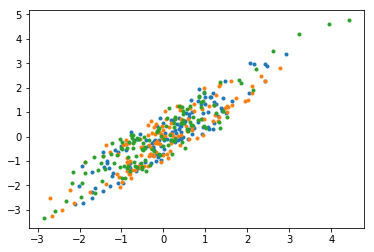

In [69]:
plot(mbp[0,:,0],pbe[0,:,0], ls = '' , marker = '.')

0.05009873230352218

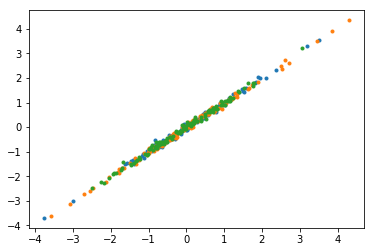

In [73]:
plot(mbp[14,:,0],corrected[14,:,0], ls = '', marker = '.')
np.sqrt(np.mean((mbp[10,:,2] - corrected[10,:,2])**2))

In [74]:
[np.sum(np.sum(corrected[:i,:,:].reshape(-1,128,3), axis = 1), axis =0) for i in range(1,len(corrected))]

[array([ 0.5577685 ,  0.69922327, -0.52756218]),
 array([ 1.24857171,  0.89004404, -0.86643957]),
 array([ 1.32898869,  1.89397012, -1.28055608]),
 array([ 1.92745668,  2.4513846 , -2.08308368]),
 array([ 2.2580771 ,  3.04642369, -1.84183284]),
 array([ 2.72735649,  3.30745149, -1.55238603]),
 array([ 3.56980352,  3.91488947, -2.13764085]),
 array([ 3.69403656,  4.79833428, -2.87679916]),
 array([ 4.43925371,  5.96069332, -3.50654838]),
 array([ 4.93735669,  6.22943191, -3.96485948]),
 array([ 5.36025027,  6.45838644, -4.71812907]),
 array([ 5.47472618,  6.4837974 , -4.98091089]),
 array([ 6.0505089 ,  6.36043339, -6.02964118]),
 array([ 6.50782897,  6.22945637, -6.98464605]),
 array([ 6.66038942,  5.80049765, -7.26057381]),
 array([ 6.95429902,  5.52345981, -8.15054349]),
 array([ 7.44536044,  5.36305995, -8.49405797]),
 array([ 7.35582503,  5.46906004, -8.82892423]),
 array([ 6.91102518,  5.79137178, -8.92130044]),
 array([ 7.08844263,  5.73674288, -9.16818029]),
 array([ 7.42589397,

In [18]:
[np.sum(np.sum(corrected[:i,:,:].reshape(-1,128,3), axis = 1), axis =0) for i in range(1,len(corrected))]

[array([ 0.2613549 ,  0.94772416, -0.56502451]),
 array([ 0.89539277,  1.50111719, -0.49645226]),
 array([ 1.06160823,  2.91921932, -0.71603209]),
 array([ 2.00634995,  3.96481202, -1.51969672]),
 array([ 2.26555969,  5.02388993, -1.10881829]),
 array([ 2.51449005,  5.93374755, -1.24345367]),
 array([ 3.29960594,  6.40460434, -1.46477621]),
 array([ 3.63075588,  7.46840747, -2.26564402]),
 array([ 4.40799507,  8.04200727, -3.30700659]),
 array([ 5.06727593,  8.15347112, -3.32026632]),
 array([ 5.68313203,  8.22041893, -3.68757339]),
 array([ 5.91058187,  8.39646935, -3.64528583]),
 array([ 6.89820723,  8.41680615, -4.39656797]),
 array([ 7.63021561,  7.93228805, -5.56517459]),
 array([ 7.94018649,  7.51911035, -6.34040531]),
 array([ 8.32582898,  7.50431375, -7.51314579]),
 array([ 8.49552484,  7.3363169 , -8.07427211]),
 array([ 8.71323997,  7.18174209, -8.9878328 ]),
 array([ 8.7044025 ,  8.10663292, -9.9883246 ]),
 array([  9.11656133,   8.21888631, -10.89920828]),
 array([  9.33035

In [13]:
import pickle
import json
import keras

In [18]:
species = 'H'
scaler = pickle.load(open('../../elf_models/old/models_masked/nn/pbe_to_mbp_16/scaler_{}'.format(species), 'rb'))
mask = np.genfromtxt('../../elf_models/old/models_masked/nn/pbe_to_mbp_16/mask_{}'.format(species), dtype=bool)
basis = json.loads(open('../../elf_models/old/models_masked/nn/pbe_to_mbp_16/basis.json','r').read())

model = mlcf.ml.Force_Network(species = species, scaler = None, basis= basis, mask=mask)

model.scaler = scaler

model.model = keras.models.load_model('../../elf_models/old/models_masked/nn/pbe_to_mbp_16/force_{}'.format(species))
model.save_all('../../elf_models/mlcf_master/pbe_to_mbp_16/')